*6132-010402D  
Гресько П.Н., Макарова М.К., Таджитдинов К.Ш.*

# Лабораторная работа 1  
##Алгоритм летучих мышей  
Алгоритм летучих мышей был предложен Синь-Янгом Янгом в 2010 году. Он основан на эхолокационном поведении летучих мышей в природе: летучие мыши используют импульсы ультразвука, чтобы обнаруживать препятствия и добычу.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import time
from sklearn.metrics import mean_squared_error

##Целевые функции:  



**Sine Wave Function**  

$f(x, y) = (x - \pi)^2 + (y - e)^2 + \sin(3x + \frac{2}{\pi}) + \sin(4y - \frac{3}{e})$  

> Гладкая, имеет множество локальных минимумов за счёт синусоидальных слагаемых

In [ ]:
def func_sine_wave(x_array: np.ndarray, y_array: np.ndarray) -> np.ndarray:
    return (x_array - 3.14) ** 2 + (y_array - 2.72) ** 2 + np.sin(3 * x_array + 1.41) + np.sin(4 * y_array - 1.73)

**Himmelblau's Function**  
$f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$


> Мультиэкстремальная, имеет 4 глобальных минимума.

In [ ]:
def func_Himmelblau(x_array: np.ndarray, y_array: np.ndarray) -> np.ndarray:
    return (x_array ** 2 + y_array - 11) ** 2 + (x_array + y_array ** 2 - 7) ** 2

**Rastrigin Function**  
$f(x, y) = A \cdot 2 + \left[x^2 - A \cos(2\pi x)\right] + \left[y^2 - A \cos(2\pi y)\right]$  


> Периодическая, сильно мультиэкстремальная, глобальный минимум в начале координат.



In [ ]:
def func_Rastrigin(x: np.ndarray, y: np.ndarray, A: float = 10) -> np.ndarray:
    return (A * 2) + (x ** 2 - A * np.cos(2 * np.pi * x)) + (y ** 2 - A * np.cos(2 * np.pi * y))

**Eggholder Function**  
$f(x, y) = -(y + 47) \sin\left(\left| \frac{x}{2} + y + 47 \right|\right) - x \sin\left(\left| x - (y + 47) \right|\right)$  


> Сложная и разрывная, имеет множество глубоких локальных минимумов



In [ ]:
def func_Eggholder(x_array, y_array):
    return -(y_array + 47) * np.sin(np.sqrt(np.abs(x_array / 2 + (y_array + 47)))) - x_array * np.sin(
        np.sqrt(np.abs(x_array - (y_array + 47))))

**Rosenbrock Function**  
$f(x, y) = (1 - x)^2 + A(y - x^2)^2$  


> Узкая долина с глобальным минимумом, сложна для оптимизации.



In [ ]:
def func_Rosenbrock(x: np.ndarray, y: np.ndarray, A: float = 100) -> np.ndarray:
    return (1 - x) ** 2 + A * (y - x ** 2) ** 2

##Визуализация

In [ ]:
#Визуализация процесса оптимизации
def display_plot(x_array: np.ndarray, y_array: np.ndarray, f_array: np.ndarray, f_name: str, x_pos: np.ndarray,
                 y_pos: np.ndarray):
    fig, ax = plt.subplots(figsize=(8, 6))

    #Отображение значений функции в виде цветовой карты
    im = ax.imshow(f_array, extent=[x_array.min(), x_array.max(), y_array.min(), y_array.max()],
                   origin='lower', cmap='viridis', alpha=0.5)
    plt.colorbar(im)

    #Нахождение глобального минимума на сетке
    x_min = x_array.ravel()[f_array.argmin()]
    y_min = y_array.ravel()[f_array.argmin()]

    #Отображение минимума
    ax.plot([x_min], [y_min], marker='x', markersize=10, color="white")

    #Изолинии функции
    contours = ax.contour(x_array, y_array, f_array, 10, colors='black', alpha=0.4)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

    ax.set_title(f"Изолинии функции {f_name}")

    #Отображение положения популяции
    scatter = ax.scatter(x_pos, y_pos, marker='x', color="black", s=5)

    #Анимация по итерациям
    def update(frame):
        scatter.set_offsets(np.column_stack((x_pos[frame], y_pos[frame])))
        ax.set_title(f"Функция: {f_name} | Итерация: {frame}")

    anim = FuncAnimation(fig, update, frames=x_pos.shape[0], interval=200)
    gif_filename = f"{f_name}_animation.gif"
    anim.save(gif_filename, writer=PillowWriter(fps=5))
    plt.show()

##Основной запуск и алгоритм летучих мышей

####Описание происходящего:  
Каждая летучая мышь ищет минимум функции, изменяя свою позицию в пространстве поиска, используя скорость, частоту, громкость (Loudness) и частоту испускания импульсов (Pulse Rate). Это поведение адаптируется с течением времени.  
Каждая летучая мышь размещается случайным образом в пространстве, и сразу вычисляется её значение функции в этой точке, также инициализируются ее скорости, частоты, громкости и импульсные параметры.  
Каждая летучая мышь:  
Выбирает частоту случайным образом.
1. Обновляет скорость в сторону лучшего найденного решения.
2. Обновляет позицию, используя эту скорость.  

Ограничивается внутри допустимого диапазона.
    
С определенной вероятностью (по Pulse Rate), летучая мышь может:
3. Совершить локальное случайное блуждание, используя среднюю громкость.
6. Принять новое положение, если оно лучше, чем текущее (меньшее значение функции).
4. Уменьшить громкость (имитирует затухание сигнала).
5. Увеличить импульсную частоту (имитирует приближение к цели).

Обновление лучшего решения:
7. Если новая позиция лучше глобального минимума — обновляется глобальный минимум.  

Таким образом, летучие мыши стремятся к глобальному минимуму, используя как информацию о текущем наилучшем решении, так и локальные случайные отклонения.

Характеристика переменных:  

| Переменная           | Описание                                             |
|----------------------|------------------------------------------------------|
| `OLD_position_x`, `OLD_position_y` | Текущие координаты летучих мышей                |
| `array_Velocity_x`, `array_Velocity_y` | Скорости перемещения по осям                 |
| `Fitness`            | Значения целевой функции для каждой летучей мыши     |
| `Loudness`           | Громкость сигнала (со временем убывает)              |
| `Pulse_Rate`         | Частота импульсов (со временем увеличивается)        |
| `best_index`, `best_fit` | Индекс и значение лучшего решения             |
| `x_pos_all`, `y_pos_all` | Массивы всех траекторий движения популяции     |
| `frequency_max`, `frequency_min` | Границы диапазона изменения частоты       |
| `Br`, `Ba`           | Коэффициенты изменения `Pulse_Rate` и `Loudness`     |


####Формулы, реализованные в алгоритме:  
1. Обновление скорости  
$
v_i(t) = v_i(t-1) + (x^* - x_i(t-1)) \cdot f_i
$

где:
- $f_i$ — частота летучей мыши,
- $x^*$ — текущее лучшее решение.  


---


2. Обновление позиции  
$
x_i(t) = x_i(t-1) + v_i(t)
$


---


3. Локальное случайное блуждание  
$
x_{\text{new}} = x_i + \bar{A} \cdot \text{rand}(-1, 1)
$

где $\bar{A}$ — средняя громкость.


---


4. Обновление громкости  
$
A_i(t+1) = \alpha \cdot A_i(t)
$


---


5. Обновление частоты импульсов  
$
r_i(t+1) = r_i^0 \cdot (1 - e^{-\gamma t})
$


---


6.  Условие приёма новой позиции  
$
f(x_{\text{new}}) \leq f(x_i)
$


---


7. Обновление глобального минимума  
$
f(x_i) < f(x^*) \Rightarrow x^* = x_i
$

In [ ]:
def bat_algorithm(func_opt, X, Y, iterations, population=30,
                  frequency_min=0.5, frequency_max=1.5,
                  a_min=0.5, a_max=2,
                  Pulse_min=0, Pulse_max=1.5,
                  Br=0.7, Ba=0.7,
                  tol=1e-9, patience=10):
    # Инициализация
    position_x = np.random.uniform(X.min(), X.max(), population)
    position_y = np.random.uniform(Y.min(), Y.max(), population)
    Fitness = func_opt(position_x, position_y)

    velocity_x = np.zeros(population)
    velocity_y = np.zeros(population)

    Loudness = a_min + (a_max - a_min) * np.random.rand(population)
    Pulse_Rate_start = Pulse_min + (Pulse_max - Pulse_min) * np.random.rand(population)
    Pulse_Rate = np.copy(Pulse_Rate_start)

    x_pos_all = np.empty((0, population))
    y_pos_all = np.empty((0, population))

    best_index = np.argmin(Fitness)
    best_fit = Fitness[best_index]

    # Критерий остановки
    best_fit_prev = best_fit
    no_improve_count = 0
    stop_iteration = iterations

    start_time = time.time()

    for step in range(iterations):
        for bat in range(population):
            Bat_Frequency = frequency_min + (frequency_max - frequency_min) * np.random.rand()

            velocity_x[bat] += (position_x[best_index] - position_x[bat]) * Bat_Frequency
            velocity_y[bat] += (position_y[best_index] - position_y[bat]) * Bat_Frequency

            new_x = position_x[bat] + velocity_x[bat]
            new_y = position_y[bat] + velocity_y[bat]

            new_x = np.clip(new_x, X.min(), X.max())
            new_y = np.clip(new_y, Y.min(), Y.max())

            if Pulse_min + (Pulse_max - Pulse_min) * np.random.rand() >= Pulse_Rate[bat]:
                k = 0
                while k < 5:
                    new_x = position_x[bat] + np.mean(Loudness) * np.random.uniform(-1, 1)
                    new_y = position_y[bat] + np.mean(Loudness) * np.random.uniform(-1, 1)

                    new_x = np.clip(new_x, X.min(), X.max())
                    new_y = np.clip(new_y, Y.min(), Y.max())

                    new_fitness = func_opt(new_x, new_y)

                    if new_fitness <= Fitness[bat]:
                        Fitness[bat] = new_fitness
                        position_x[bat] = new_x
                        position_y[bat] = new_y
                        Loudness[bat] *= Ba
                        Pulse_Rate[bat] = Pulse_Rate_start[bat] * (1 - np.exp(-Br * (step + 1)))
                        break
                    k += 1

            if Fitness[bat] < best_fit:
                best_index = bat
                best_fit = Fitness[best_index]

        x_pos_all = np.concatenate((x_pos_all, position_x.reshape(1, population)))
        y_pos_all = np.concatenate((y_pos_all, position_y.reshape(1, population)))

        # Проверка критерия остановки
        if abs(best_fit_prev - best_fit) < tol:
            no_improve_count += 1
        else:
            no_improve_count = 0
            best_fit_prev = best_fit

        if no_improve_count >= patience:
            stop_iteration = step + 1
            #print(f"Критерий остановки достигнут на итерации: {stop_iteration}")
            break

    elapsed_time = time.time() - start_time
    best_x = position_x[best_index]
    best_y = position_y[best_index]

    return best_x, best_y, best_fit, x_pos_all, y_pos_all, elapsed_time, stop_iteration

Оптимизируемая функция: sine_wave
Глобальный минимум на сетке: f(3.18318, 3.12813) = -1.80831

Найденный минимум:
f(3.18437, 3.12813) = -1.80832
RMSE: 0.00084
Среднее время выполнения: 4.18 секунд
Средняя итерация остановки: 28.4


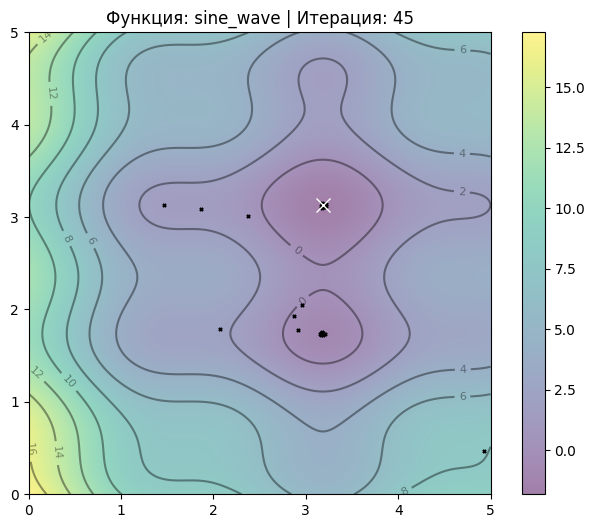

In [ ]:
name_func = "sine_wave"
#name_func = "Himmelblau"
#name_func = "Rastrigin"
#name_func = "Rosenbrock"
#name_func = "Eggholder"

dic_func = {"sine_wave": [func_sine_wave, 0, 5],
            "Himmelblau": [func_Himmelblau, -5, 5],
            "Rastrigin": [func_Rastrigin, -5.12, 5.12],
            "Rosenbrock": [func_Rosenbrock, -3, 3],
            "Eggholder": [func_Eggholder, -512, 512]}

func_opt = dic_func[name_func][0]
min_x = dic_func[name_func][1]
max_x = dic_func[name_func][2]

num = 1000
x = np.linspace(min_x, max_x, num)
y = np.linspace(min_x, max_x, num)
X, Y = np.meshgrid(x, y)
f_array = func_opt(X, Y)

# Глобальный минимум на сетке
min_index = np.unravel_index(np.argmin(f_array), f_array.shape)
x_min = X[min_index]
y_min = Y[min_index]
min_val = f_array[min_index]

iterations = 100

#Параметры алгоритма летучих мышей
frequency_max = 1.5
frequency_min = 0.5

a_min = 0.5
a_max = 2

Pulse_max = 1.5
Pulse_min = 0

Br = 0.7  #параметр затухания Pulse_Rate
Ba = 0.7  #параметр затухания Loudness

num_runs = 20

best_x_list = []
best_y_list = []
best_fit_list = []
rmse_list = []
time_list = []
stop_iter_list = []

# Чтобы сохранить позиции для лучшего результата
best_run_index = None
best_run_x_pos_all = None
best_run_y_pos_all = None

for i in range(num_runs):
    best_x, best_y, best_fit, x_pos_all, y_pos_all, elapsed_time, stop_iteration = bat_algorithm(
        func_opt, X, Y, iterations, population=30, frequency_min=frequency_min, frequency_max=frequency_max,
        a_min=a_min, a_max=a_max, Pulse_min=Pulse_min, Pulse_max=Pulse_max, Br=Br, Ba=Ba)

    best_x_list.append(best_x)
    best_y_list.append(best_y)
    best_fit_list.append(best_fit)
    time_list.append(elapsed_time)
    stop_iter_list.append(stop_iteration)

    rmse = np.sqrt(mean_squared_error([[x_min, y_min]], [[best_x, best_y]]))
    rmse_list.append(rmse)

    if best_run_index is None or rmse < rmse_list[best_run_index]:
        best_run_index = i
        best_run_x_pos_all = x_pos_all
        best_run_y_pos_all = y_pos_all

mean_x = np.mean(best_x_list)
mean_y = np.mean(best_y_list)
mean_fit = np.mean(best_fit_list)
mean_rmse = np.mean(rmse_list)
mean_time = np.mean(time_list)
mean_stop_iter = np.mean(stop_iter_list)

best_index = np.argmin(rmse_list)

best_x_best = best_x_list[best_index]
best_y_best = best_y_list[best_index]
best_fit_best = best_fit_list[best_index]
best_rmse_best = rmse_list[best_index]

print(f"Оптимизируемая функция: {name_func}")
print(f"Глобальный минимум на сетке: f({x_min:.5f}, {y_min:.5f}) = {min_val:.5f}\n")

print(f"Найденный минимум:")
print(f"f({best_x_best:.5f}, {best_y_best:.5f}) = {best_fit_best:.5f}")
print(f"RMSE: {best_rmse_best:.5f}")
print(f"Среднее время выполнения: {mean_time:.2f} секунд")
print(f"Средняя итерация остановки: {mean_stop_iter:.1f}")

display_plot(X, Y, f_array, name_func, best_run_x_pos_all, best_run_y_pos_all)

####Результаты (алгоритм летучих мышей):

| Функция       | Глобальный минимум на сетке           | Средняя итерация остановки | Найденный минимум               | RMSE    | Среднее время выполнения (с) |
|---------------|--------------------------------------|----------------------------|--------------------------------|---------|------------------------------|
| sine_wave     | f(3.18318, 3.12813) = -1.80831       | 30                         | f(3.18443, 3.12952) = -1.80835 | 0.00132 | 4.60                         |
| Himmelblau    | f(2.99800, 1.99700) = 0.00042         | 32                         | f(2.99942, 2.00127) = 0.00003   | 0.00318 | 4.54                         |
| Rastrigin     | f(-0.00513, -0.00513) = 0.01042       | 18.4                       | f(-0.02982, -0.00797) = 0.18844 | 0.01757 | 2.76                         |
| Rosenbrock    | f(1.00000, 1.00000) = 0.00000         | 29.1                       | f(0.99962, 0.99880) = 0.00002   | 0.00089 | 4.00                         |
| Eggholder     | f(512.00000, 404.37237) = -959.61818  | 76                         | f(512.00000, 417.74864) = -745.17749 | 9.45845 | 7.19                     |


##Градиентный спуск

Стохастический градиентный спуск — это метод оптимизации, использующий градиенты функции для минимизации или максимизации параметров модели. В отличие от классического градиентного спуска, который использует полную информацию о функции на всей выборке, стохастический градиентный спуск обновляет параметры на основе случайных выборок данных.  


1. **Инициализация**: случайным образом выбираются начальные значения для параметров $x$ и $y$.

2. **Вычисление градиента**: для случайной точки $(x, y)$ вычисляется градиент функции потерь по $x$ и $y$:
   
   $$
   \nabla f(x, y) = \left( \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right)
   $$

3. **Обновление параметров**: параметры обновляются по формуле:
   
   $$
   x_{\text{new}} = x_{\text{old}} - \eta \cdot \frac{\partial f}{\partial x}, \quad y_{\text{new}} = y_{\text{old}} - \eta \cdot \frac{\partial f}{\partial y}
   $$
   
   где $\eta$ — это шаг обучения (или коэффициент обновления).

4. **Ограничение**: обновленные значения ограничиваются в пределах заранее заданных границ.

5. **Повторение**: шаги 2-4 повторяются для заданного числа итераций.

Математическое выражение градиентов:

- Градиент по $x$:
  
  $$
  \text{grad}_x = \frac{f(x + \epsilon, y) - f(x - \epsilon, y)}{2\epsilon}
  $$

- Градиент по $y$:
  
  $$
  \text{grad}_y = \frac{f(x, y + \epsilon) - f(x, y - \epsilon)}{2\epsilon}
  $$


In [ ]:
def compute_gradient(func, x, y):
    epsilon = 1e-5
    grad_x = (func(x + epsilon, y) - func(x - epsilon, y)) / (2 * epsilon)
    grad_y = (func(x, y + epsilon) - func(x, y - epsilon)) / (2 * epsilon)
    return grad_x, grad_y

In [ ]:
#name_func = "Himmelblau"
#name_func = "Rastrigin"
#name_func = "Rosenbrock"
#name_func = "Eggholder"
name_func = "sine_wave"

dic_func = {"sine_wave": [func_sine_wave, 0, 5],
            "Himmelblau": [func_Himmelblau, -5, 5],
            "Rastrigin": [func_Rastrigin, -5.12, 5.12],
            "Rosenbrock": [func_Rosenbrock, -3, 3],
            "Eggholder": [func_Eggholder, -512, 512]}

func_opt = dic_func[name_func][0]
min_x = dic_func[name_func][1]
max_x = dic_func[name_func][2]

tol = 1e-9
patience = 10

num = 1000
x = np.linspace(min_x, max_x, num)
y = np.linspace(min_x, max_x, num)
X, Y = np.meshgrid(x, y)
f_array = func_opt(X, Y)

min_index = np.unravel_index(np.argmin(f_array), f_array.shape)
x_min = X[min_index]
y_min = Y[min_index]
min_val = f_array[min_index]

print(f"Оптимизируемая функция: {name_func}")
print(f"Глобальный минимум на сетке: f({x_min:.5f}, {y_min:.5f}) = {min_val:.5f}\n")

steps = 0.01
iterations = 100
runs = 20

# Для усреднения результатов по 20 запускам
best_fits = []
rmse_all = []
times = []
iterations_stopped = []
best_xs = []
best_ys = []

for run in range(runs):
    current_x = np.random.uniform(X.min(), X.max())
    current_y = np.random.uniform(Y.min(), Y.max())
    x_pos_all = []
    y_pos_all = []

    start_time = time.time()

    best_fit = func_opt(current_x, current_y)
    best_x, best_y = current_x, current_y
    no_improve_count = 0
    stop_iter = iterations  # итерация остановки

    for step in range(iterations):
        random_x = np.random.uniform(X.min(), X.max())
        random_y = np.random.uniform(Y.min(), Y.max())

        grad_x, grad_y = compute_gradient(func_opt, random_x, random_y)

        current_x -= steps * grad_x
        current_y -= steps * grad_y

        current_x = np.clip(current_x, X.min(), X.max())
        current_y = np.clip(current_y, Y.min(), Y.max())

        current_fit = func_opt(current_x, current_y)

        if best_fit - current_fit > tol:
            best_fit = current_fit
            best_x, best_y = current_x, current_y
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            stop_iter = step + 1
            break

        x_pos_all.append(current_x)
        y_pos_all.append(current_y)

    end_time = time.time()
    elapsed_time = end_time - start_time

    rmse = np.sqrt(((x_min - best_x) ** 2 + (y_min - best_y) ** 2) / 2)

    best_fits.append(best_fit)
    best_xs.append(best_x)
    best_ys.append(best_y)
    rmse_all.append(rmse)
    times.append(elapsed_time)
    iterations_stopped.append(stop_iter)

mean_x = np.mean(best_xs)
mean_y = np.mean(best_ys)
mean_fit = np.mean(best_fits)

print(f"Среднее количество итераций: {np.mean(iterations_stopped):.1f}")
print(f"Среднее время: {np.mean(times):.2f} сек")
print(f"Найденный минимум: f({mean_x:.5f}, {mean_y:.5f}) = {mean_fit:.5f}")
print(f"RMSE: {np.mean(rmse_all):.5f}")

#x_pos_all = np.array(x_pos_all).reshape(-1, 1)
#y_pos_all = np.array(y_pos_all).reshape(-1, 1)
#display_plot(X, Y, f_array, name_func, x_pos_all, y_pos_all)

Оптимизируемая функция: sine_wave
Глобальный минимум на сетке: f(3.18318, 3.12813) = -1.80831

Среднее количество итераций: 23.4
Среднее время: 0.08 сек
Найденный минимум: f(3.02620, 2.75029) = 2.46621
RMSE: 1.14946


#### Результаты (градиентный спуск):

| Оптимизируемая функция | Глобальный минимум на сетке           | Среднее количество итераций | Среднее время (сек) | Найденный минимум                   | RMSE     |
|------------------------|---------------------------------------|------------------------------|---------------------|--------------------------------------|----------|
| sine_wave              | f(3.18318, 3.12813) = -1.80831        | 20.4                         | 0.07                | f(3.17820, 2.43771) = 3.13741        | 1.26326  |
| Himmelblau             | f(2.99800, 1.99700) = 0.00042         | 16.1                         | 0.05                | f(0.42302, -0.17433) = 34.81891      | 3.10941  |
| Rastrigin              | f(-0.00513, -0.00513) = 0.01042       | 16.3                         | 0.05                | f(0.86018, 1.02981) = 18.23443       | 2.47319  |
| Rosenbrock             | f(1.00000, 1.00000) = 0.00000         | 14.9                         | 0.06                | f(0.21207, 1.55188) = 460.26667      | 1.62554  |
| Eggholder              | f(512.00000, 404.37237) = -959.61818  | 21.3                         | 0.06                | f(34.47161, 0.33472) = 4.02136       | 476.15025|


##Метод Ньютона

Метод Ньютона — это численный метод оптимизации, используемый для поиска локального минимума (или максимума) функции. Он основывается на аппроксимации функции с помощью её второй степени (квадратичного приближения) и использует градиент и гессиан для определения направления и величины шага.  
Гессиан — это квадратная матрица вторых производных функции.

**Градиент (вектор первых производных):**

$$
\nabla f(x, y) =
\begin{bmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}
\end{bmatrix}
$$

**Гессиан (матрица вторых производных):**

$$
H(x, y) =
\begin{bmatrix}
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\
\frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2}
\end{bmatrix}
$$

**Обновление по методу Ньютона:**

$$
x_{k+1} = x_k - H^{-1}(x_k) \cdot \nabla f(x_k)
$$

**Если H вырожден, используется псевдообратная матрица:**

$$
x_{k+1} = x_k - (H + \epsilon I)^{-1} \cdot \nabla f(x_k)
$$

**Приближённое численное вычисление второй производной (конечные разности):**

$$
f_{xx} \approx \frac{f(x + \varepsilon, y) - 2f(x, y) + f(x - \varepsilon, y)}{\varepsilon^2}
$$

$$
f_{yy} \approx \frac{f(x, y + \varepsilon) - 2f(x, y) + f(x, y - \varepsilon)}{\varepsilon^2}
$$

$$
f_{xy} \approx \frac{f(x + \varepsilon, y + \varepsilon) - f(x + \varepsilon, y - \varepsilon) - f(x - \varepsilon, y + \varepsilon) + f(x - \varepsilon, y - \varepsilon)}{4\varepsilon^2}
$$


In [ ]:
def compute_hessian(func, x, y):
    epsilon = 1e-5
    f_xx = (func(x + epsilon, y) - 2 * func(x, y) + func(x - epsilon, y)) / epsilon ** 2
    f_yy = (func(x, y + epsilon) - 2 * func(x, y) + func(x, y - epsilon)) / epsilon ** 2
    f_xy = (func(x + epsilon, y + epsilon) - func(x + epsilon, y - epsilon)
            - func(x - epsilon, y + epsilon) + func(x - epsilon, y - epsilon)) / (4 * epsilon ** 2)
    return np.array([[f_xx, f_xy],
                     [f_xy, f_yy]])

In [ ]:
#name_func = "sine_wave"
#name_func = "Himmelblau"
#name_func = "Rastrigin"
name_func = "Rosenbrock"
#name_func = "Eggholder"

dic_func = {"sine_wave": [func_sine_wave, 0, 5],
            "Himmelblau": [func_Himmelblau, -5, 5],
            "Rastrigin": [func_Rastrigin, -5.12, 5.12],
            "Rosenbrock": [func_Rosenbrock, -3, 3],
            "Eggholder": [func_Eggholder, -512, 512]}

func_opt = dic_func[name_func][0]
min_x = dic_func[name_func][1]
max_x = dic_func[name_func][2]

num = 1000
x = np.linspace(min_x, max_x, num)
y = np.linspace(min_x, max_x, num)
X, Y = np.meshgrid(x, y)
f_array = func_opt(X, Y)

min_index = np.unravel_index(np.argmin(f_array), f_array.shape)
x_min = X[min_index]
y_min = Y[min_index]
min_val = f_array[min_index]

print(f"Оптимизируемая функция: {name_func}")
print(f"Глобальный минимум на сетке: f({x_min:.5f}, {y_min:.5f}) = {min_val:.5f}\n")

# Параметры
runs = 20
iterations = 300
tol = 1e-9
patience = 10

best_fits = []
best_xs = []
best_ys = []
rmse_all = []
times = []
iterations_stopped = []

for run in range(runs):
    current = np.array([
        np.random.uniform(min_x, max_x),
        np.random.uniform(min_x, max_x)
    ])

    best_fit = func_opt(current[0], current[1])
    no_improve_count = 0
    stop_iter = iterations

    x_pos_all = []
    y_pos_all = []

    start_time = time.time()

    for i in range(iterations):
        grad = compute_gradient(func_opt, current[0], current[1])
        hess = compute_hessian(func_opt, current[0], current[1])

        try:
            delta = np.linalg.solve(hess, grad)
        except np.linalg.LinAlgError:
            delta = np.linalg.lstsq(hess + np.eye(2) * 1e-4, grad, rcond=None)[0]

        current -= delta
        current[0] = np.clip(current[0], min_x, max_x)
        current[1] = np.clip(current[1], min_x, max_x)

        x_pos_all.append(current[0])
        y_pos_all.append(current[1])

        current_fit = func_opt(current[0], current[1])

        if abs(best_fit - current_fit) < tol:
            no_improve_count += 1
        else:
            best_fit = current_fit
            no_improve_count = 0

        if no_improve_count >= patience:
            stop_iter = i + 1
            break

    end_time = time.time()
    elapsed_time = end_time - start_time

    best_x, best_y = current[0], current[1]
    rmse = np.sqrt(((x_min - best_x)**2 + (y_min - best_y)**2) / 2)

    best_fits.append(best_fit)
    best_xs.append(best_x)
    best_ys.append(best_y)
    rmse_all.append(rmse)
    times.append(elapsed_time)
    iterations_stopped.append(stop_iter)

    #print(f"[{run+1:02}] Остановлено на итерации: {stop_iter}, f({best_x:.5f}, {best_y:.5f}) = {best_fit:.5f}, RMSE = {rmse:.5f}")

# Усреднённые значения
mean_x = np.mean(best_xs)
mean_y = np.mean(best_ys)
mean_fit = np.mean(best_fits)

print(f"Среднее количество итераций: {np.mean(iterations_stopped):.1f}")
print(f"Среднее время выполнения: {np.mean(times):.2f} секунд")
print(f"Найденный минимум: f({mean_x:.5f}, {mean_y:.5f}) = {mean_fit:.5f}")
print(f"RMSE: {np.mean(rmse_all):.5f}")

Оптимизируемая функция: Rosenbrock
Глобальный минимум на сетке: f(1.00000, 1.00000) = 0.00000

Среднее количество итераций: 45.4
Среднее время выполнения: 0.00 секунд
Найденный минимум: f(1.00000, 1.00000) = 0.00000
RMSE: 0.00000


####Результаты (метод Ньютона)

| Оптимизируемая функция | Глобальный минимум на сетке           | Среднее количество итераций | Среднее время (сек) | Найденный минимум                   | RMSE     |
|------------------------|---------------------------------------|------------------------------|---------------------|--------------------------------------|----------|
| sine_wave              | f(3.18318, 3.12813) = -1.80831        | 144.2                        | 0.01                | f(2.34854, 2.33476) = 5.04451        | 1.55849  |
| Himmelblau             | f(2.99800, 1.99700) = 0.00042         | 15.1                         | 0.00                | f(-0.10122, -0.43104) = 36.33083     | 3.24182  |
| Rastrigin              | f(-0.00513, -0.00513) = 0.01042       | 13.8                         | 0.01                | f(-0.77946, 0.95129) = 30.80379      | 2.47196  |
| Rosenbrock             | f(1.00000, 1.00000) = 0.00000         | 42.0                         | 0.00                | f(1.00000, 1.00000) = 0.00000        | 0.00000  |
| Eggholder              | f(512.00000, 404.37237) = -959.61818  | 56.9                         | 0.01                | f(18.14510, 64.39838) = -24.72344    | 476.35185|


##Вывод:

###По точности нахождения минимума:

Алгоритм летучих мышей показал наивысшую точность нахождения глобального минимума на всех тестовых функциях.

  * sine_wave, Himmelblau, Rastrigin, Rosenbrock  — RMSE близок к нулю.
  * На сложной функции Eggholder результат близок к оптимальному значению.

Градиентный спуск и метод Ньютона продемонстрировали значительные отклонения от глобального минимума. Единственное исключение — метод Ньютона на Rosenbrock, где он точно достиг глобального минимума.

###По скорости выполнения:

Метод Ньютона — самый быстрый, но его высокая скорость достигается за счёт сильной зависимости от выбора начальной точки, что делает его уязвимым на сложных функциях.

Градиентный спуск — немного медленнее, но стабильнее на простых задачах.

Алгоритм летучих мышей — самый медленный, но выигрывает в качестве найденного решения.

###По числу итераций до сходимости:

Метод Ньютона требует много итераций на некоторых функциях.

Градиентный спуск — умеренное число итераций, но часто сходится к локальным минимумам.

Алгоритм летучих мышей — умеренное число итераций.



**Таким образом, для задач, где приоритет — точность алгоритм летучих мышей — лучший выбор, несмотря на большую затрату времени.**